In [2]:
%load_ext autoreload
%autoreload 2

import sys
print(f"Python version: {sys.version} ")
print(f"Require >= 3.9")

import numpy as np
import matplotlib.pyplot as plt
import iapws95_light

# Cython-backend imports
import float_phi_functions
import float_mix_functions
import iapws95_light_perf
import mixtureWLM

Python version: 3.9.1 (tags/v3.9.1:1e5d33e, Dec  7 2020, 17:08:21) [MSC v.1927 64 bit (AMD64)] 
Require >= 3.9


In [3]:
iapws95_light_perf.print_timing()

Timing iapws95_light_perf calculations for scalar input.
=== Individual routines ===
phi0         : 0.23 us
phi0_d       : 0.13 us
phi0_dd      : 0.12 us
phi0_t       : 0.15 us
phi0_tt      : 0.16 us
phi0_dt      : 0.13 us
phir         : 3.86 us
phir_d       : 3.46 us
phir_dd      : 3.75 us
phir_t       : 3.87 us
phir_tt      : 3.94 us
phir_dt      : 3.52 us
=== Reference ops (pure python) ===
rho * R * T  : 0.12 us
(rho*T)**.5  : 0.21 us
lambda no-op : 0.06 us
=== Optimized routines ===
phir_*       : 1.15 us
phi0_*       : 0.42 us
phir_d_dd    : 0.89 us


In [29]:
# WLMA model special case: ya = 0.0
from time import perf_counter
import scipy.optimize

K = mixtureWLM.K
p_m0 = mixtureWLM.p_m0
rho_m0 = mixtureWLM.rho_m0
v_m0 = 1.0 / rho_m0
c_v_m0 = 3e3
ya = 0.0

def run_float_mix_function(yw, T, rhow):
  ''' Run manager with rhow as 3rd input '''
  # Compute dependent quantities
  p_target = float_phi_functions.p(rhow, T)
  if p_target < 1e5 or p_target > 100e6:
    # Skip
    return np.nan, np.nan, 0.0, np.nan
  rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
  rho_mix = 1.0/(yw / rhow + (1 - yw) / rhom )
  uw_target = float_phi_functions.u(rhow, T)
  um_target = c_v_m0 * T \
    + float_mix_functions.magma_mech_energy(p_target, K , p_m0, rho_m0)
  u_target = yw*uw_target + (1-yw)*um_target 
  vol_energy = rho_mix * u_target
  rho_target = rho_mix
  T_target = T
  # Run with timer
  N_samples = 1
  t1 = perf_counter()
  for i in range(N_samples):
    _out = float_mix_functions.conservative_to_pT_WLMA(vol_energy, rho_mix,
      yw, ya, K, p_m0, rho_m0, c_v_m0, 287, 1.4)
    p = _out["p"]
    T = _out["T"]
  t2 = perf_counter()
  return p, p_target, (t2-t1)/N_samples, T

v_yw = np.linspace(0.01, 1-1e-9, 375)
v_T = np.linspace(280, 1600, 260)
v_rhow = np.linspace(0.5, 1050, 60)

mg_yw, mg_T, mg_rhow = np.meshgrid(v_yw, v_T, v_rhow, indexing="ij")
# mg_yw, mg_T, mg_p = np.meshgrid(v_yw, v_T, v_p, indexing="ij")

mg_p_calc = np.empty_like(mg_yw)
mg_p_target = np.empty_like(mg_yw)
mg_wallt = np.empty_like(mg_yw)
mg_T_calc = np.empty_like(mg_yw)

for i, j, k in np.ndindex(mg_yw.shape):
  mg_p_calc[i,j,k], mg_p_target[i,j,k], mg_wallt[i,j,k], mg_T_calc[i,j,k] = \
    run_float_mix_function(mg_yw[i,j,k], mg_T[i,j,k], mg_rhow[i,j,k])

Text(0, 0.5, 'counts')

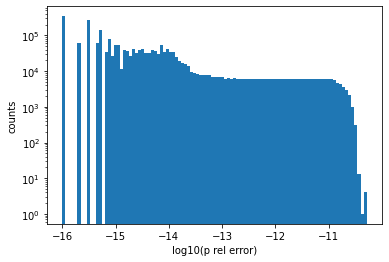

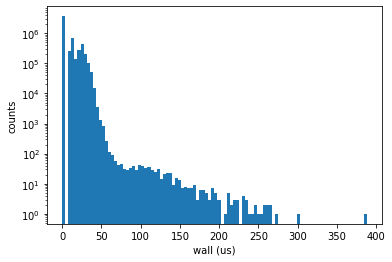

In [30]:
''' Histogram WLMA at ya = 0'''
plt.figure()
# plt.hist(np.clip(np.log10(np.abs(mg_p_calc / mg_p_target - 1.0).ravel()), -16, -7), bins=100, log=True)
# supcrit_indices = np.where(mg_T.ravel()>=iapws95_light.Tc)
plt.hist(np.log10(1e-16+np.abs(mg_p_calc / mg_p_target - 1.0).ravel()[:]), bins=100, log=True)
plt.xlabel("log10(p rel error)")
plt.ylabel("counts")
plt.figure()
plt.hist(mg_wallt.ravel()*1e6, bins=100, log=True)
plt.xlabel("wall (us)")
plt.ylabel("counts")

In [33]:
float_phi_functions.p(998, 300)

3326528.466173707

In [34]:
def prim_to_cons(yw, T, rhow, ya):
# Compute dependent quantities
  p_target = float_phi_functions.p(rhow, T)
  if p_target < 1e5 or p_target > 100e6:
    # Skip
    return yw, np.nan, np.nan
  rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
  rhoa = p_target / (R_a * T)
  rho_mix = 1.0/(yw / rhow + (1 - yw - ya) / rhom + ya / rhoa)
  uw_target = float_phi_functions.u(rhow, T)
  um_target = c_v_m0 * T \
    + float_mix_functions.magma_mech_energy(p_target, K , p_m0, rho_m0)
  ua_target = R_a / (gamma_a - 1.0) * T
  u_target = yw*uw_target + (1-yw-ya)*um_target + ya*ua_target
  vol_energy = rho_mix * u_target
  return (yw, vol_energy, rho_mix)

## Middleware test

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import mixtureWLMA
import float_phi_functions
import float_mix_functions
wlm = mixtureWLMA.WLM()

# WLMA model special case: ya = 0.0
from time import perf_counter
import scipy.optimize
import numpy as np

ya = 0.0
# Compute conservative variables from primitives
R_a = 287
gamma_a = 1.4
rho_m0 = wlm.rho_m0
K = wlm.K
p_m0 = wlm.p_m0
c_v_m0 = wlm.c_v_m0

# Define fallback values for testing
rhow_test_fallback = 998
T_test_fallback = 300

def prim_to_cons_with_default(yw, T, rhow, ya=0.0):
# Compute dependent quantities
  p_target = float_phi_functions.p(rhow, T)
  used_default = False
  if p_target < 1e5 or p_target > 200e6:
    # Revert to default rhow, T
    rhow, T = rhow_test_fallback, T_test_fallback
    p_target = float_phi_functions.p(rhow, T)
    used_default = True
  rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
  rhoa = p_target / (R_a * T)
  rho_mix = 1.0/(yw / rhow + (1 - yw - ya) / rhom + ya / rhoa)
  uw_target = float_phi_functions.u(rhow, T)
  um_target = c_v_m0 * T \
    + float_mix_functions.magma_mech_energy(p_target, K , p_m0, rho_m0)
  ua_target = R_a / (gamma_a - 1.0) * T
  u_target = yw*uw_target + (1-yw-ya)*um_target + ya*ua_target
  vol_energy = rho_mix * u_target
  return (yw, vol_energy, rho_mix, p_target, used_default)

# Fill primitives
v_yw = np.linspace(0.001, 1-1e-9, 375) # 375
v_T = np.linspace(280, 1600, 26)  # 260
v_rhow = np.linspace(0.5, 1050, 30) # 60
# Fill conservatives, roll into index0
mg_yw, mg_T, mg_rhow = np.meshgrid(v_yw, v_T, v_rhow, indexing="ij")
mg_p = np.empty_like(mg_T)
U = np.zeros((mg_yw.size,1,9))
for serial_i, (i, j, k) in enumerate(np.ndindex(mg_yw.shape)):
  _yw, _vol_energy, _rho_mix, mg_p[i,j,k], _used_default = \
    prim_to_cons_with_default(mg_yw[i,j,k], mg_T[i,j,k], mg_rhow[i,j,k])
  # Modify mg
  if _used_default:
    mg_rhow[i,j,k], mg_T[i,j,k] = rhow_test_fallback, T_test_fallback
  
  U[serial_i, 0, 0:3] = [0.0, _yw*_rho_mix, (1.0-_yw)*_rho_mix]
  U[serial_i, 0, 5:6] = _vol_energy

In [2]:
''' Check correctness of middleware function '''
_out_pTvf_native = wlm.pTvf_native(U[...,0:3], U[...,3:5], U[...,5:6])
# Nan check
yw_nan = (U[...,1] / U[...,0:3].sum(axis=-1)).ravel()[
    np.where(np.isnan(_out_pTvf_native[0].ravel()))]
print(f"nan occurences: {yw_nan}")
# Value check
max_diff_rhow = np.max(np.abs(mg_rhow.ravel() - _out_pTvf_native[0].ravel()))
max_diff_p = np.max(np.abs(mg_p.ravel() - _out_pTvf_native[1].ravel()))
max_diff_T = np.max(np.abs(mg_T.ravel() - _out_pTvf_native[2].ravel()))
print(f"Max difference in rhow: {max_diff_rhow}; in p: {max_diff_p}")
print(f"Max sound speed encountered: {_out_pTvf_native[3].ravel().max()}")

nan occurences: []
Max difference in rhow: 1.8325181372347288e-09; in p: 0.00015438534319400787
Max sound speed encountered: 1849.0320951821116


In [5]:
''' Compare implementations of middleware function: native vs. python-map '''
_out_pTvf_map = wlm.pTvf_map(U[...,0:3], U[...,3:5], U[...,5:6])
print(f"Inf-norm difference of map and native outputs: " +
      f"{np.linalg.norm(np.array(_out_pTvf_map[0] - _out_pTvf_native[0]))}")

Inf-norm difference of map and native outputs: 0.0


In [8]:
# Timing for middleware on typical size (ne=3000, nb=6)
%timeit wlm.pTvf_native(U[0:18000,0:1,0:3], U[0:18000,0:1,3:5], U[0:18000,0:1,5:6])
%timeit wlm.pTvf_map(U[0:18000,0:1,0:3], U[0:18000,0:1,3:5], U[0:18000,0:1,5:6])

451 ms ± 822 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
